<a href="https://www.kaggle.com/code/karan842/brain-tumor-detection?scriptVersionId=118104595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumor Detection by using MRI Images🧠🩺

In [3]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [4]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set_style('darkgrid')
%matplotlib inline
init_notebook_mode(connected=True)
RANDOM_SEED = 101

## Dataset

- `NO` - no tumor, encoded as `0`
- `YES` - tumor, encoded as `1`

 Right now all images are in one folder with yes and no subfolders. I will split the data into train, val and test folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [5]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [6]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

## Data import and Preprocessing

In [7]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i=0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _  = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.51it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 49.70it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 17.46it/s]

50 images loaded from VAL/ directory.


## Distribution of classes among sets:

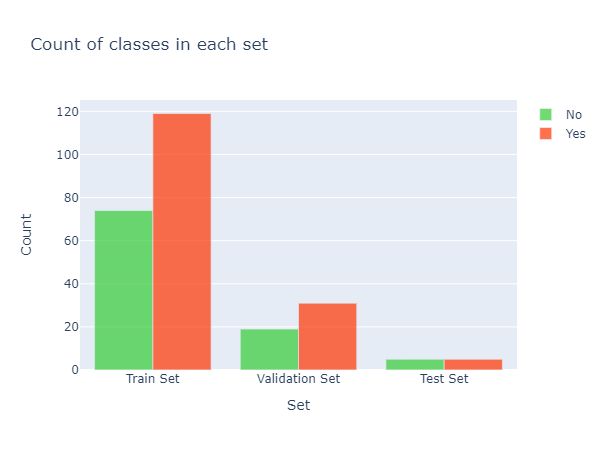

In [9]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title':'Set'},
    yaxis={'title':'Count'}
)
fig = go.Figure(data,layout)
iplot(fig)

## Plot samples

In [10]:
def plot_samples(X,y,labels_dict, n=50):
    """
        Create a gridplot for desired number of images (n) from specified set
    """ 
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y==index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

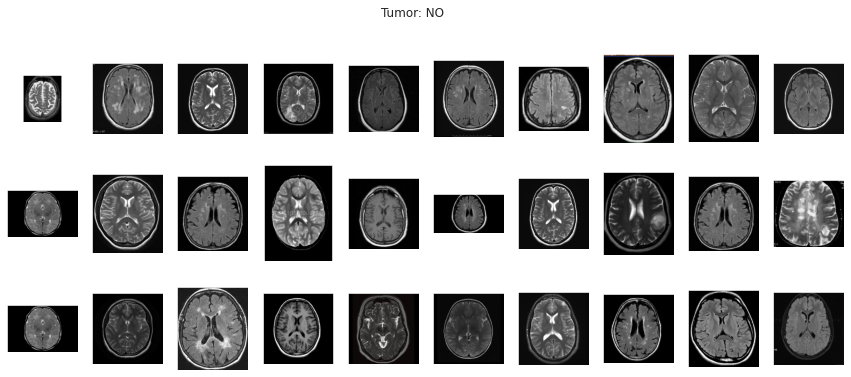

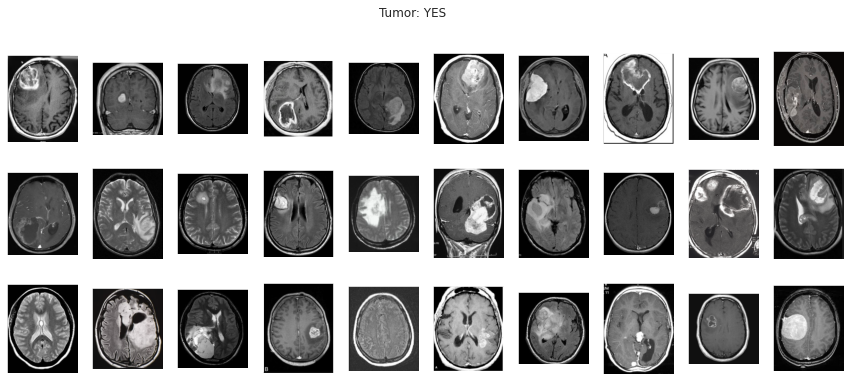

In [11]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different width and height and diffent size of "black corners". Since the image size for VGG-16 imput layer is (224,224) some wide images may look weird after resizing. Histogram of ratio distributions (ratio = width/height):

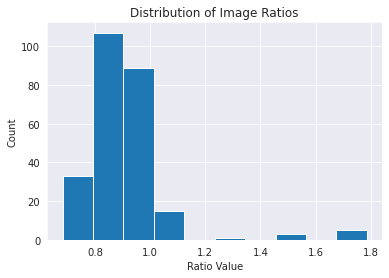

In [12]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images.

`Erosion is an operation that erodes away the boundaries of foreground objects. It is performed by applying a structuring element (kernel) to the image and replacing the central pixel of the kernel with the minimum value of the pixels under the kernel. This reduces the size of the foreground objects and eliminates small white pixels (noise) from the image.

Dilation is the opposite of erosion. It expands the boundaries of the foreground objects by replacing the central pixel of the kernel with the maximum value of the pixels under the kernel. This increases the size of the foreground objects and fills small holes in the objects.`

In [13]:
def crop_imgs(set_name, add_pixels_value=0):
    """
        Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5,5), 0)
        '''
            is used to blur an image by applying a Gaussian filter to it. 
            The Gaussian filter is a type of low-pass filter that is used to remove 
            noise and high-frequency information from an image, 
            making it appear smoother and less grainy.
        '''
        
        # threshold the image then perform a series of erosions + 
        # dilations to remove any small region of noise
        
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        '''
        Thresholding is a process of converting an image into a binary image based on a specified threshold value. 
        The pixels in the image are compared to the threshold value, 
        and if the value of a pixel is greater than the threshold value, 
        it is set to 255 (white), otherwise it is set to 0 (black).
        '''
        thresh = cv2.erode(thresh, None, iterations=2)
        
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find the contours in threshold image, then grad the largest one
        '''
         defined as the boundaries of an object in an image. They can be thought of as the curves that enclose an object in an image 
         and separate it from the rest of the image. 
         Contours are a powerful tool for image analysis and processing, as they provide information 
         about the shape, size, and orientation of objects in an image.
        '''
        cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :,0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 0].argmin()][0])
        extBot = tuple(c[c[:, :, 0].argmax()][0])
        
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                     extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
    return np.array(set_new)

In [14]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

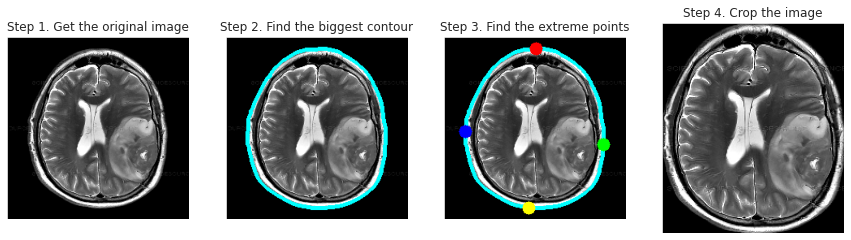

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.show()

# Pre-preocssing the data for CNN

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
encoder = OneHotEncoder()
encoder.fit([[0],[1]])

# 0 -> Tumor
# 1 -> Normal

OneHotEncoder()

## Creating 3 important lists

1. data list for storing image data in numpy array form
2. Paths list for storing paths of all images

3. Result list for storing one hot encoded form of target class wheter normal tumor

In [18]:
# for tumor
from PIL import Image
data = []
paths = []
result = []

for r, d, f in os.walk(r'../input/brain-mri-images-for-brain-tumor-detection/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r,file))
for path in paths:
        img = Image.open(path)
        img = img.resize((128,128))
        img = np.array(img)
        if(img.shape==(128,128,3)):
            data.append(np.array(img))
            result.append(encoder.transform([[0]]).toarray())

In [19]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"../input/brain-mri-images-for-brain-tumor-detection/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [20]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [21]:
result = np.array(result)
result = result.reshape(139,2)

In [22]:
result.shape

(139, 2)

## Splitting the data into training and testing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data,result,test_size=0.2,shuffle=True,random_state=42)

## Model Building

> Batch Normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing number of training epochs required to train 

# ChatGPT questions:

### What are the pros and cons of using `BatchNormalization`

Batch normalization is a technique used in deep learning to normalize the activations of a layer across a batch of input data, so that the mean and variance of the activations remain the same across different batches. Batch normalization can help to stabilize the training process and reduce the risk of overfitting, especially in deep neural networks with many layers.

However, there are situations where batch normalization may not be necessary or even harmful. Here are some factors to consider when deciding whether to use batch normalization:

- Network depth: Batch normalization is particularly useful for deep neural networks with many layers, as it can help prevent the -vanishing or exploding gradients problem.

- Data size: If you have a small amount of training data, batch normalization may not be necessary as the model is likely to overfit even without batch normalization.

- Model stability: Batch normalization can make the training process more stable, but it can also slow down the training process, as normalizing the activations across a batch adds computational overhead.

- Data distribution: If your input data has a highly non-uniform distribution, batch normalization may not be effective, as the normalization will be based on the mean and variance of each batch, which may not accurately reflect the distribution of the entire dataset.

In general, it's a good idea to try both with and without batch normalization, and compare the performance of your model on your validation set to determine whether batch normalization is beneficial for your problem. If you find that batch normalization is slowing down your training process without improving performance, you may consider not using it.

In [24]:
from tensorflow.keras.layers import Conv2D,BatchNormalization, MaxPooling2D,Dropout,Flatten,Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(128,128,3),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=3, activation='relu',padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

2023-02-03 08:20:01.227036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:20:01.228208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:20:01.344669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:20:01.345569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:20:01.346433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

#### Pictorial representation of `model summary`

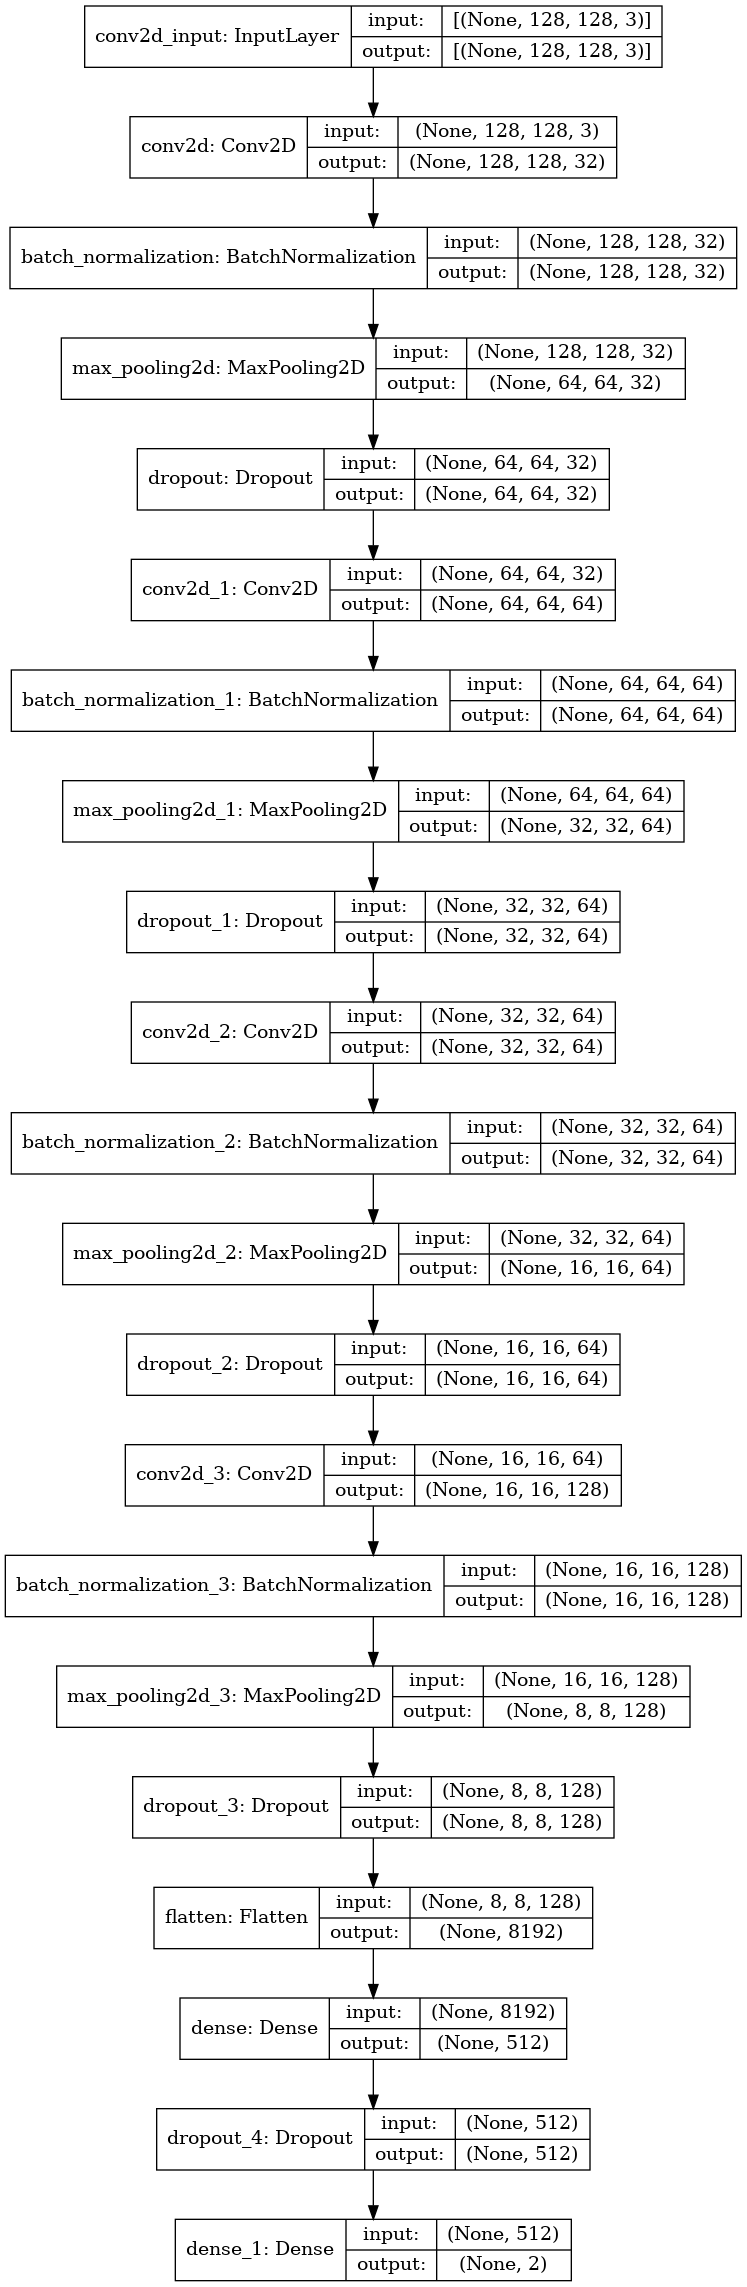

In [26]:
from tensorflow.keras.utils import plot_model

# Plot the model summary
plot_model(model, to_file='model_summary.png', show_shapes=True)

In [27]:
history1 = model.fit(X_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (X_test, y_test))

2023-02-03 08:20:06.504654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-03 08:20:08.646094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 [==============================] - 11s 423ms/step - loss: 13.4128 - accuracy: 0.4505 - val_loss: 43.0820 - val_accuracy: 0.4643
Epoch 2/30
3/3 [==============================] - 0s 35ms/step - loss: 9.4806 - accuracy: 0.5045 - val_loss: 11.0830 - val_accuracy: 0.4643
Epoch 3/30
3/3 [==============================] - 0s 36ms/step - loss: 2.1489 - accuracy: 0.6937 - val_loss: 32.8062 - val_accuracy: 0.5357
Epoch 4/30
3/3 [==============================] - 0s 36ms/step - loss: 3.1724 - accuracy: 0.6937 - val_loss: 18.8605 - val_accuracy: 0.5357
Epoch 5/30
3/3 [==============================] - 0s 36ms/step - loss: 1.8955 - accuracy: 0.7207 - val_loss: 5.7780 - val_accuracy: 0.6429
Epoch 6/30
3/3 [==============================] - 0s 36ms/step - loss: 0.8227 - accuracy: 0.7748 - val_loss: 4.1665 - val_accuracy: 0.6786
Epoch 7/30
3/3 [==============================] - 0s 35ms/step - loss: 0.7161 - accuracy: 0.6757 - val_loss: 6.3347 - val_accuracy: 0.5000
Epoch 8/30
3/3 [===============

#### We can see that the difference between accuracy and val_accuracy are very high that means over model is overfitted 

## Hyperparamter Tuning

- Above model is just a baseline model now we will tune the model for better performance

In [28]:
import keras_tuner as kt

In [29]:
def build_model(hp):
    model = Sequential()
    
    # hyper_parameter variables
    unit_1 = hp.Int('unit_1', min_value=32,max_value=512,step=32)
    do1_ = hp.Choice('do1_',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    model.add(Conv2D(unit_1, kernel_size=3, activation='relu',input_shape=(128,128,3),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(do1_))

    unit_2 = hp.Int('unit_2', min_value=32,max_value=512,step=32)
    do2_ = hp.Choice('do2_',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    model.add(Conv2D(unit_2, kernel_size=3, activation='relu',padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(do2_))
    
    unit_3 = hp.Int('unit_3', min_value=32,max_value=512,step=32)
    do3_ = hp.Choice('do3_',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    model.add(Conv2D(unit_3, kernel_size = 3, activation ='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(do3_))

    unit_4 = hp.Int('unit_4',min_value=32, max_value=512,step=32)
    do4_ = hp.Choice('do4_',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    model.add(Conv2D(128, kernel_size = 3, activation ='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    unit_5 = hp.Int('unit_5',min_value=32, max_value=512,step=32)
    do5_ = hp.Choice('do5_',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    model.add(Dense(unit_5, activation='relu'))
    model.add(Dropout(do5_))
    op_act = hp.Choice('op_act',values=['sigmoid','tanh'])
    model.add(Dense(2,activation=op_act))

    optimizer = hp.Choice('opt_1',values=['sgd','adam','rmsprop','adadelta'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [30]:
# initializing the tuner
tuner = kt.RandomSearch(build_model,
                       objective='val_accuracy',
                       max_trials=5,
                       directory='tumor_detecton',
                       project_name='2st_trial')

In [31]:
tuner.search(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Trial 5 Complete [00h 01m 23s]
val_accuracy: 0.8928571343421936

Best val_accuracy So Far: 0.8928571343421936
Total elapsed time: 00h 05m 48s


In [32]:
## get best hperparameters
tuner.get_best_hyperparameters()[0].values

{'unit_1': 160,
 'do1_': 0.7,
 'unit_2': 448,
 'do2_': 0.1,
 'unit_3': 416,
 'do3_': 0.5,
 'unit_4': 224,
 'do4_': 0.1,
 'unit_5': 192,
 'do5_': 0.2,
 'op_act': 'sigmoid',
 'opt_1': 'adam'}

In [33]:
## get the top model architecture
model_tuned = tuner.get_best_models(num_models=1)[0]

In [34]:
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 160)     4480      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 160)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 160)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 448)       645568    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 448)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 448)       0

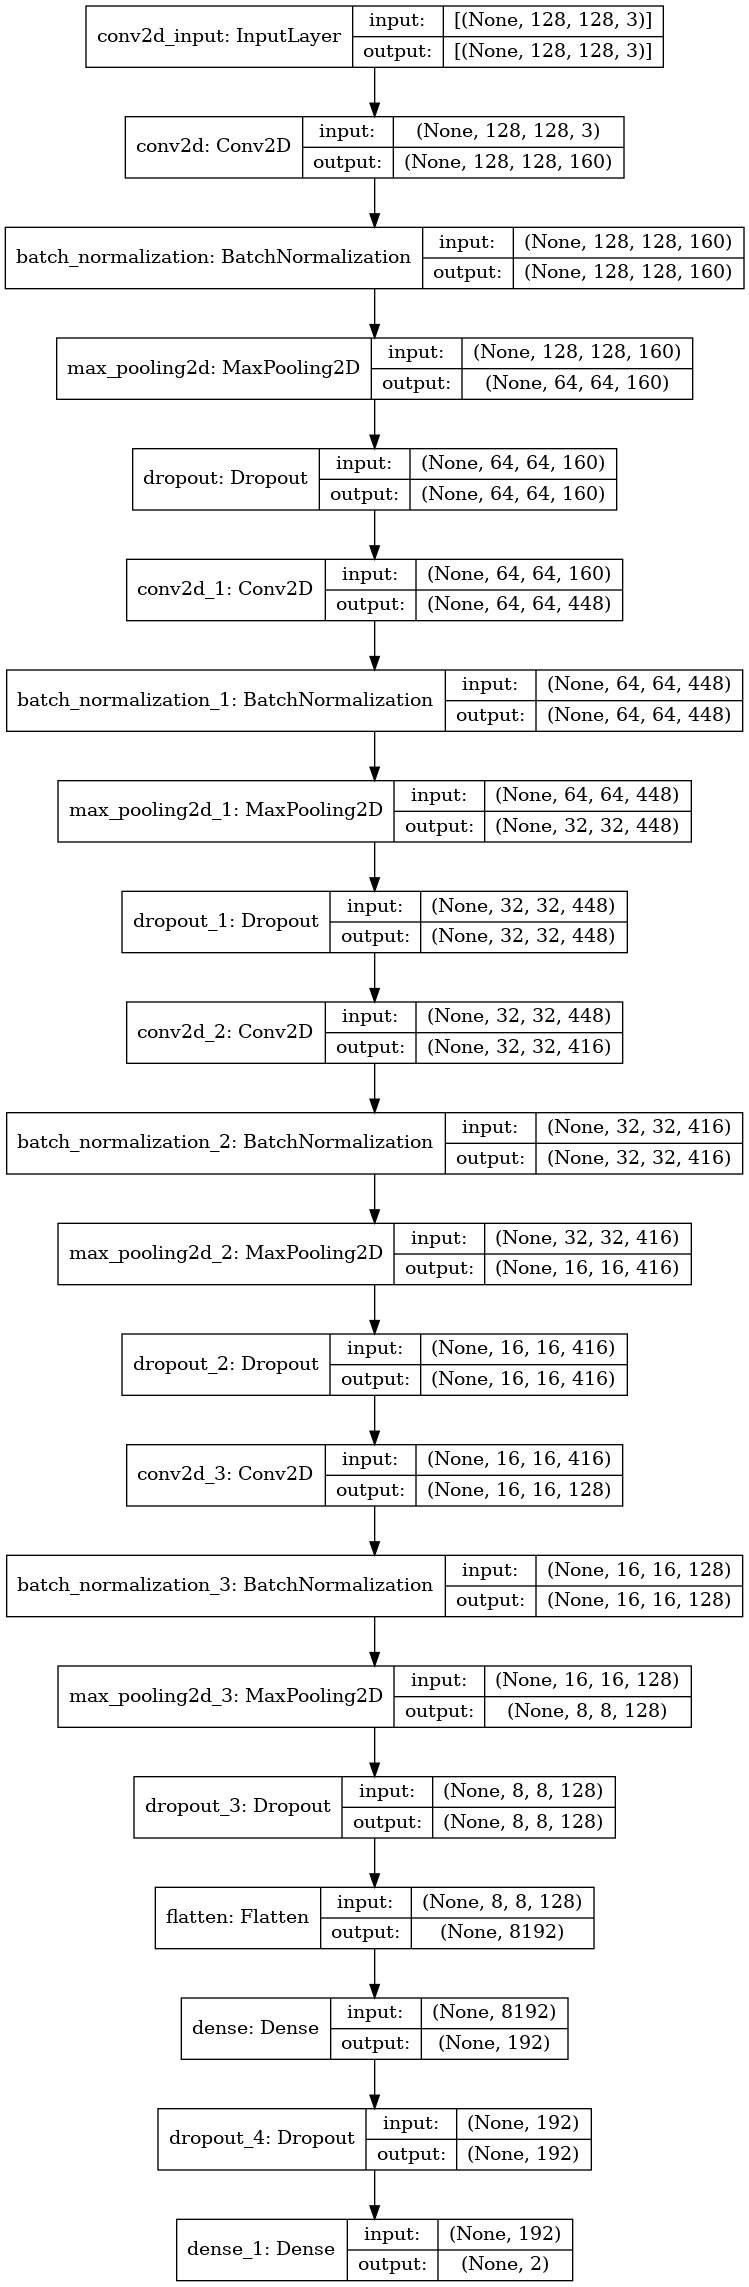

In [35]:
# Plot the model summary
plot_model(model_tuned, to_file='model_summary.png', show_shapes=True)

## Training the Tuned model

In [36]:
history2 = model_tuned.fit(X_train, y_train, batch_size=32,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
4/4 [==============================] - 2s 216ms/step - loss: 0.0165 - accuracy: 0.9910 - val_loss: 0.5145 - val_accuracy: 0.8571
Epoch 2/100
4/4 [==============================] - 1s 149ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.4481 - val_accuracy: 0.8571
Epoch 3/100
4/4 [==============================] - 1s 157ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.4050 - val_accuracy: 0.8571
Epoch 4/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.4732 - val_accuracy: 0.7143
Epoch 5/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.5828 - val_accuracy: 0.7500
Epoch 6/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.6903 - val_accuracy: 0.6786
Epoch 7/100
4/4 [==============================] - 1s 150ms/step - loss: 0.0250 - accuracy: 0.9820 - val_loss: 0.5295 - val_accuracy: 0.7143
Epoch 8/100
4

## Lets plot the performance of epochs and loss

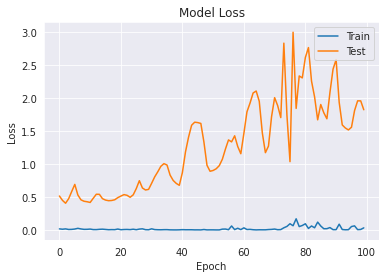

In [37]:
# Plot the loss
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();

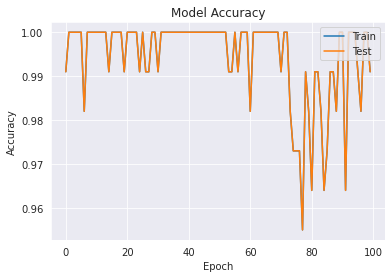

In [38]:
# plot the epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();

### Our model (fine_tuned) does not perform well on the image data. We'll optimize our model by

- Re-arraning last CNN architecture
- Train the data using `transfer learning.`